<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Singapore Housing Data and Kaggle Challenge <br> [Part 2 of 2]

_Prepared by: Timothy Chan, 3 Mar 2023_

## Contents:
- [Preproccessing](#Preproccessing)
- [Modelling](#Modelling)
- [Evaluation](#Evaluation)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

**Part 2** of Project 2 will primarily cover the Preprocessing, Modelling and Recommendations. For Data Cleaning and Exploratory Data Analysis (EDA), please refer to **Part 1**.

### Data Dictionary

Data dictionary of cleaned training and testing files before performing one-hot encoding.

|Features|Type|Dataset|Description|
|:---|:---|:---|:---|
|id|float|flats_test_cleaned.csv||
|resale_price|float|flats_cleaned.csv|Property's sale price in Singapore dollars. Our target variable to predict|
|floor_area_sqft|float|both|Floor area of the resale flat unit in square feet|
|price_per_sqft|float|both|Price in Singapore dollars for each square feet of floor area. Not to use for model|
|street_name|string|both|Street name where the resale flat resides. For reference only|
|address|string|both|Address where the resale flat resides. For reference only|
|latitude|float|both|Latitude based on postal code. For reference only|
|longitude|float|both|Longtitude based on postal code. For reference only|
|flat_type|string|both|Type of the resale flat unit, e.g. 3 ROOM|
|flat_model|string|both|HDB model of the resale flat, e.g. Multi Generation|
|planning_area|string|both|Government planning area that the flat is located|
|postal_sector|integer|both|first two digits of six digit postal code|
|max_floor_lvl|integer|both|Highest floor of the resale flat|
|mid_storey|integer|both|Estimated floor level of unit based on median value of storey range|
|hdb_age|integer|both|Number of years from lease commencement date to year of data (2021)|
|mrt_interchange|integer|both|boolean value if the nearest MRT station is also a train interchange|
|bus_interchange|integer|both|boolean value if the nearest MRT station is a bus interchange station|
|mrt_nearest_distance|float|both|distance in metres to the nearest MRT station|
|hawker_nearest_distance|float|both|distance in metres to the nearest hawker centre|
|distance_to_cityhall|float|both|distance in metres to the CBD|
|hawker_within_2km_imp|float|both|number of hawker centres within 2 kilometres (missing values imputed)|
|mall_within_2km_imp|float|both|number of malls within 2 kilometres (missing values imputed)|
|total_dwelling_units|integer|both|total number of residential dwelling units in the resale flat|
|commercial|integer|both|if resale flat has commercial units in the same block|
|flat_type_tgt|float|both|target encoding of mean price per sqft of each category of flat type|
|flat_model_tgt|float|both|target encoding of mean price per sqft of each category of flat model|
|planning_area_tgt|float|both|target encoding of mean price per sqft of each category of planning area|
|postal_sector_tgt|float|both|target encoding of mean price per sqft of each category of postal sector|

--- 
## Preproccessing
---

**Import**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error

In [2]:
# Import data
flats = pd.read_csv("datasets/flats_cleaned.csv") # train data
flats_test = pd.read_csv("datasets/flats_test_cleaned.csv") # test data

**One hot encoding using sklearn**

In [3]:
columns_tf = ['flat_type', 'flat_model', 'planning_area']
for col in columns_tf:
    flats[col] = flats[col].apply(lambda x: x.replace(" ", "_").replace("-", "_").lower())
    flats_test[col] = flats_test[col].apply(lambda x: x.replace(" ", "_").replace("-", "_").lower())    

In [4]:
# One hot encode for train and test data
columns_onehot = ['flat_type', 'flat_model', 'planning_area', 'postal_sector']

encoder = OneHotEncoder()

# Fit encoder to columns and get the feature names
encoder.fit(flats[columns_onehot])
feature_names = encoder.get_feature_names_out(columns_onehot)

# Create new Dataframe to hold one-hot encoded columns
one_hot_df = pd.DataFrame(data=encoder.transform(flats[columns_onehot]).toarray(), columns=feature_names) # train data
test_one_hot_df = pd.DataFrame(data=encoder.transform(flats_test[columns_onehot]).toarray(), columns=feature_names) # test data

# Concatenate one-hot encoded columns to training dataset
flats = pd.concat([flats, one_hot_df], axis=1) # train data
flats_test = pd.concat([flats_test, test_one_hot_df], axis=1) # test data

# Drop original columns
flats.drop(columns=columns_onehot, inplace=True) # train data
flats_test.drop(columns=columns_onehot, inplace=True) # test data

In [5]:
flats.head()

,resale_price,floor_area_sqft,price_per_sqft,street_name,address,latitude,longitude,max_floor_lvl,mid_storey,hdb_age,...,postal_sector_64,postal_sector_65,postal_sector_66,postal_sector_67,postal_sector_68,postal_sector_73,postal_sector_75,postal_sector_76,postal_sector_79,postal_sector_82
0,680000.0,968.760,701.928238,UPP BOON KENG RD,"3B, UPP BOON KENG RD",1.314299,103.872828,25,11,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,665000.0,1399.320,475.230826,BISHAN ST 13,"153, BISHAN ST 13",1.346086,103.855078,9,8,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,838000.0,1550.016,540.639580,BT BATOK ST 25,"289B, BT BATOK ST 25",1.343867,103.760535,16,14,24,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,550000.0,1108.692,496.080066,BISHAN ST 22,"232, BISHAN ST 22",1.358245,103.845504,11,3,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,298000.0,893.412,333.552717,YISHUN ST 81,"876, YISHUN ST 81",1.414745,103.835532,4,2,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
flats.shape

(150634, 134)

In [7]:
flats_test.head()

,id,floor_area_sqft,price_per_sqft,street_name,address,latitude,longitude,max_floor_lvl,mid_storey,hdb_age,...,postal_sector_64,postal_sector_65,postal_sector_66,postal_sector_67,postal_sector_68,postal_sector_73,postal_sector_75,postal_sector_76,postal_sector_79,postal_sector_82
0,114982,904.176,399.258551,YISHUN AVE 7,"173, YISHUN AVE 7",1.437066,103.831121,12,8,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,95653,1205.568,398.152572,JURONG WEST ST 93,"986C, JURONG WEST ST 93",1.336957,103.695668,14,5,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40303,731.952,479.386626,ANG MO KIO AVE 10,"534, ANG MO KIO AVE 10",1.374058,103.854168,12,8,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,109506,1044.108,306.481705,MARSILING DR,"29, MARSILING DR",1.442748,103.772922,14,2,42,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100149,1108.692,360.784600,BT BATOK WEST AVE 8,"170, BT BATOK WEST AVE 8",1.346556,103.740101,25,17,36,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
flats_test.shape

(16737, 134)

--- 
## Modelling
---

**Methodology** <br>
As this is a regression problem, we will model using either linear regression, ridge or lasso models.

The train data will be split 75:25 into training and validation sets respectively. <br>
There will be standard scaling fitted on the training data before apply transformation on the training, validation and test sets.
Cross validation will be done on the training set before comparing against the validation set. Selected models will be used to predict the score on the test set for the kaggle submission.

For ridge, we will use a 5 folds cross validation for the training set instead of 10 folds due to the longer run time for this particular project.
For linear regression and lasso, we will use a 10 folds cross validation for the training set.

Evaluation will be based on root mean square error (RMSE) score while taking into consideration the number of features used.

In [9]:
# Create a function to to obtain the RMSE and alpha if applicable, based on given scaled train and validation sets

def rmse_model(X_train, X_val, y_train, y_val, model, feature, cv_input): # for model: to input 'lr'/'ridge'/'lasso'  
    if model == 'lr':
        model_input = LinearRegression()
    elif model == 'ridge':
        model_input = RidgeCV(alphas=np.linspace(0.5, 20, 200), cv=cv_input)
    elif model == 'lasso':
        model_input = LassoCV(n_alphas=200, cv=10)
    else:
        raise ValueError("Model type must be one of 'lr', 'ridge', 'lasso' ")
    
    model_input.fit(X_train, y_train)
    model_rmse = -cross_val_score(model_input, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = cv_input)
    model_rmse_val = np.sqrt(mean_squared_error(y_val, model_input.predict(X_val)))

    # Get coefficients
    coef = model_input.coef_
    
    print(f"{feature} / {model.upper()} RMSE train: {round(model_rmse.mean(), 2)}")
    print(f"{feature} / {model.upper()} RMSE val: {round(model_rmse_val, 2)}")
    
    if model in ('ridge', 'lasso'):
        print(f"best alpha: {round(model_input.alpha_,2)}")
        
    return (model_input, coef)

In [10]:
# Store resale_price as y
y = flats['resale_price']

### Features A: All features

For the first feature, we will use all features listed with planning_area for location. <br>
(1) Linear Regression will be used to gauge how well the model performs for RMSE. <br>
(2) Ridge and (3) Lasso will also be used to regularise and reduce overfitting, and to see what features are most useful.

In [11]:
features_a = [
    'floor_area_sqft',
    
    'max_floor_lvl',
    'mid_storey',
    'hdb_age',
    'bus_interchange',
    'mrt_interchange',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'distance_to_cityhall',
    'total_dwelling_units',
    'commercial',
    'hawker_within_2km_imp',
    'mall_within_2km_imp',

#    'flat_type_1_room',        ##drop this as base for one-hot
    'flat_type_2_room',
    'flat_type_3_room',
    'flat_type_4_room',
    'flat_type_5_room',
    'flat_type_executive',
    'flat_type_multi_generation',

#    'flat_model_2_room',        ##drop this as base for one-hot
    'flat_model_adjoined_flat',
    'flat_model_apartment',
    'flat_model_dbss',
    'flat_model_improved',
    'flat_model_improved_maisonette',
    'flat_model_maisonette',
    'flat_model_model_a',
    'flat_model_model_a2',
    'flat_model_model_a_maisonette',
    'flat_model_multi_generation',
    'flat_model_new_generation',
    'flat_model_premium_apartment',
    'flat_model_premium_apartment_loft',
    'flat_model_premium_maisonette',
    'flat_model_simplified',
    'flat_model_standard',
    'flat_model_terrace',
    'flat_model_type_s1',
    'flat_model_type_s2',
    
#    'planning_area_ang_mo_kio',   ##drop this as base for one-hot
    'planning_area_bedok',
    'planning_area_bishan',
    'planning_area_bukit_batok',
    'planning_area_bukit_merah',
    'planning_area_bukit_panjang',
    'planning_area_bukit_timah',
    'planning_area_changi',
    'planning_area_choa_chu_kang',
    'planning_area_clementi',
    'planning_area_downtown_core',
    'planning_area_geylang',
    'planning_area_hougang',
    'planning_area_jurong_east',
    'planning_area_jurong_west',
    'planning_area_kallang',
    'planning_area_marine_parade',
    'planning_area_novena',
    'planning_area_outram',
    'planning_area_pasir_ris',
    'planning_area_punggol',
    'planning_area_queenstown',
    'planning_area_rochor',
    'planning_area_sembawang',
    'planning_area_sengkang',
    'planning_area_serangoon',
    'planning_area_tampines',
    'planning_area_tanglin',
    'planning_area_toa_payoh',
    'planning_area_western_water_catchment',
    'planning_area_woodlands',
    'planning_area_yishun',
    ]

# Number of features
len(features_a)

69

In [12]:
X_1 = flats[features_a]

# Train/test split to have holdout set
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y, random_state=42)

In [13]:
# Scale features
ss = StandardScaler()
ss.fit(X_train_1)
X_train_1 = ss.transform(X_train_1)
X_val_1 = ss.transform(X_val_1)

**Model 1 (Features A): Linear Regression**

In [14]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation  
rmse_model(X_train_1, X_val_1, y_train_1, y_val_1, 'lr', 'Features_A', 10)

Features_A / LR RMSE train: 50961.79
Features_A / LR RMSE val: 50570.82


(LinearRegression(),
 array([ 8.25547407e+04,  2.21521500e+04,  1.85661849e+04, -4.18308879e+04,
         5.82662135e+03,  1.76642736e+03, -2.48990746e+04, -1.13257644e+04,
        -3.33531018e+04, -6.69754176e+03, -1.51685353e+03,  2.18350469e+04,
        -4.87814849e+02, -1.91139828e+03,  3.90492165e+03,  1.03423474e+04,
         1.47361816e+04,  1.26612089e+04,  1.29085519e+16,  2.48877845e+03,
        -5.71803253e+02,  8.05070458e+03, -1.38800385e+04,  1.50492315e+03,
         4.45159163e+03, -1.50851987e+04, -2.66455323e+03,  3.20452832e+03,
        -1.29085519e+16, -5.98505704e+03, -6.77230852e+03,  1.00031173e+03,
         6.87320716e+02, -3.58571331e+03, -3.35414251e+03,  9.13954844e+03,
         2.93956805e+03,  3.89877636e+03,  1.65033204e+03,  1.12457394e+04,
         4.44140889e+03,  4.93542134e+03, -4.52726064e+03,  9.69427910e+03,
         5.00051551e+03, -3.90963414e+03,  1.00441733e+04,  1.45991555e+03,
        -7.43561595e+02, -4.73970450e+02,  3.60788990e+03,  3.18338

**Model 2 (Features A): Ridge Regularisation**

In [15]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
rmse_model(X_train_1, X_val_1, y_train_1, y_val_1, 'ridge', 'Features_A', 5)

Features_A / RIDGE RMSE train: 50963.46
Features_A / RIDGE RMSE val: 50571.95
best alpha: 6.87


(RidgeCV(alphas=array([ 0.5       ,  0.59798995,  0.6959799 ,  0.79396985,  0.8919598 ,
         0.98994975,  1.0879397 ,  1.18592965,  1.2839196 ,  1.38190955,
         1.4798995 ,  1.57788945,  1.6758794 ,  1.77386935,  1.8718593 ,
         1.96984925,  2.0678392 ,  2.16582915,  2.2638191 ,  2.36180905,
         2.45979899,  2.55778894,  2.65577889,  2.75376884,  2.85175879,
         2.94974874,  3.04773869,  3.14572864,  3.24371859,  3.34170854,
         3.43969849,  3.5...
        17.15829146, 17.25628141, 17.35427136, 17.45226131, 17.55025126,
        17.64824121, 17.74623116, 17.84422111, 17.94221106, 18.04020101,
        18.13819095, 18.2361809 , 18.33417085, 18.4321608 , 18.53015075,
        18.6281407 , 18.72613065, 18.8241206 , 18.92211055, 19.0201005 ,
        19.11809045, 19.2160804 , 19.31407035, 19.4120603 , 19.51005025,
        19.6080402 , 19.70603015, 19.8040201 , 19.90201005, 20.        ]),
         cv=5),
 array([ 8.25074704e+04,  2.21671593e+04,  1.86127842e+04, -4.

**Model 3 (Feature A): Lasso Regularisation**

In [16]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
lasso_1_output = rmse_model(X_train_1, X_val_1, y_train_1, y_val_1, 'lasso', 'Features_A', 10)
lasso_1_output # to print RMSE and alpha

lasso_1_coef = lasso_1_output[-1] # to pull coeff for lasso

Features_A / LASSO RMSE train: 50977.23
Features_A / LASSO RMSE val: 50606.31
best alpha: 93.7


Findings: <br>
All 3 models based on Features A have similar results at RMSE of around 51,000. <br>
The cross-validation of training set yielded similar RMSE score when compared to the hold-out validation set. <br>

alpha is not very big for Regularisation models which means that there was not much regularisation done. This could explain why the models have similar RMSE. Also, it could mean that there is not much over-fitting, which explains why the training and validation set have similar RMSE scores.

This will be the baseline score where we will try to improve the score or decrease the number of features while maintaining the score.

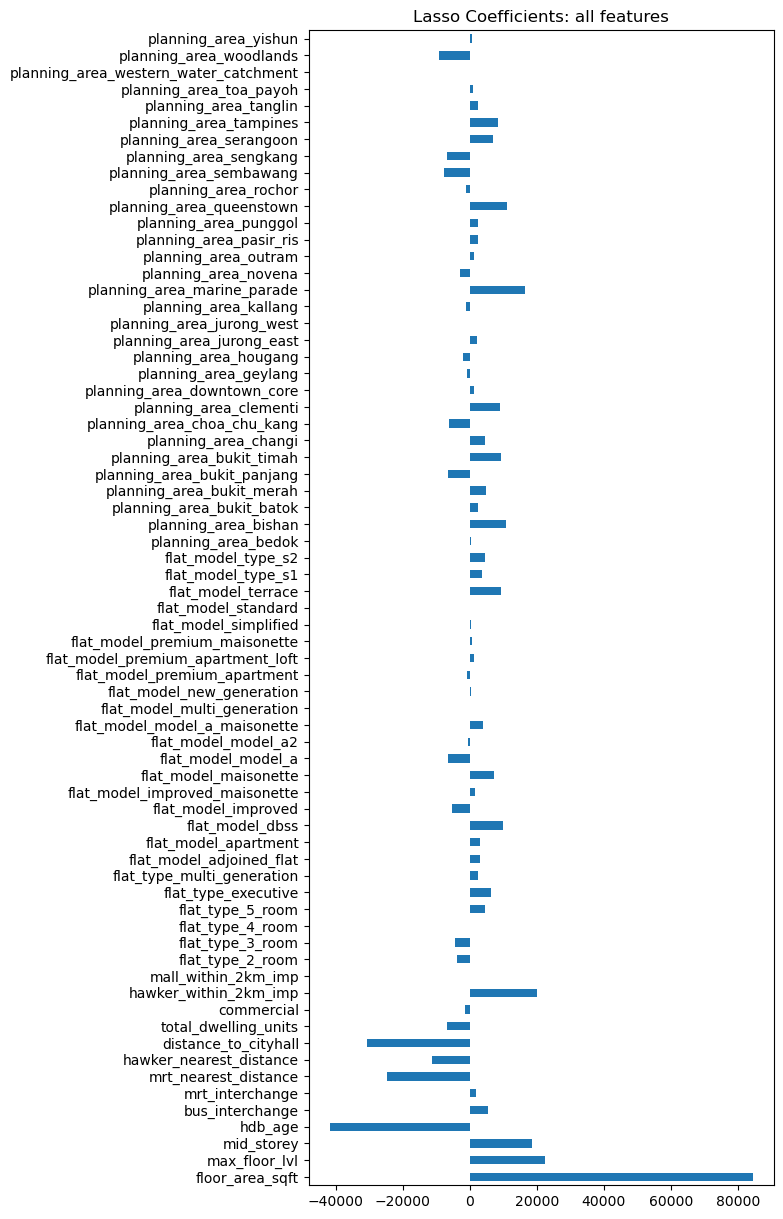

In [17]:
# All coefficients from Model 3: Lasso, based on Features A
pd.Series(lasso_1_coef, index=features_a).plot.barh(figsize=(6,15))
plt.title("Lasso Coefficients: all features");

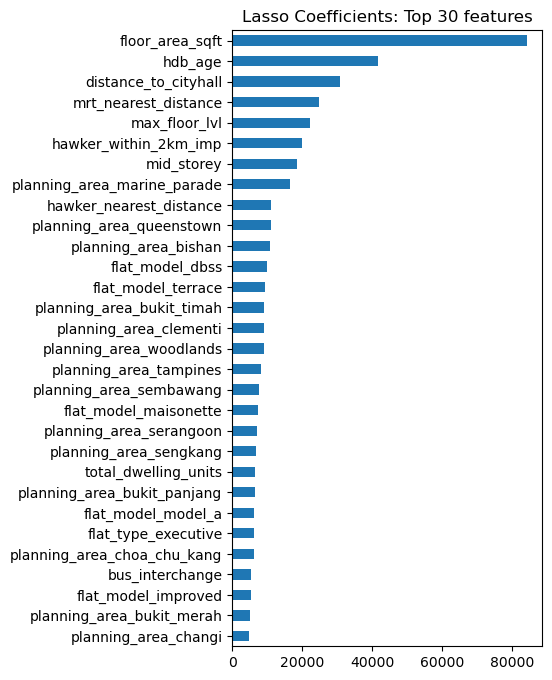

In [18]:
# Filter to narrow down to top 30 features and sorted
lasso_top30 = pd.Series(lasso_1_coef, index=features_a).abs().nlargest(30).sort_values()

lasso_top30.plot.barh(figsize=(4,8))
plt.title("Lasso Coefficients: Top 30 features");

Findings: <br>
The bargraph of all features shows the magnitude and direction of impact of each feature within Features A, when regularised using Lasso. A few features were dropped by the regularisation.  

Based on top 30 bargraph,
- *floor area* has the most impact by far (about 2x the next feature), followed by *hdb age*. This is as expected.
- followed by *convenience* related features (distance to CityHall, nearest MRT and hawker; number of hawkers within 2km).
- *Height* of flat and unit and *location* features (based on planning area) are next. Location wise, a flat in Woodlands will result in lower prices while Marine Parade can command the highest prices in this model.
- Some flat *type and model* are also within the top 30 in terms of impact. Of note are DBSS, Terrace and Maisonette models and Executive flat types which command higher prices. These are premium or rarer flats. Model A and Improved will result in lower prices.
- Total number of dwelling units also has a negative impact to prices. This could be due to density of the flat and less exclusivity or more noise, which will make it less attractive.

Although from EDA in *Part 1*, there were some features which showed correlation, and by right one of these should be excluded to avoid adding noise and causing overfitting, there does not seem to be such issues with overfitting when comparing training and validation sets.
- highest floor and estimated floor
- highest floor and hdb age
- distance to nearest hawker and hdb age
- distance to cityhall and hawker features
- distance to nearest hawker and number of hawkers within 2km

The top 30 features impacting the lasso model will be selected for Features B.

### Features B: Reduced features

We reduced the number of features to keep only the top 30 features which has the biggest impact to the model, while expecting to sacrifice some RMSE score. Features relate to:
- area size
- lease age
- convenience (e.g. distance to CityHall, nearest MRT and hawker)
- height of flat and unit
- selected locations
- selected flat models or types
- total dwelling units

In [19]:
# List out top 30 features from Model 3 Lasso
lasso_top30.sort_values(ascending=False)

floor_area_sqft                84294.727414
hdb_age                        41689.637857
distance_to_cityhall           30753.369587
mrt_nearest_distance           24760.224384
max_floor_lvl                  22357.066399
hawker_within_2km_imp          19981.683449
mid_storey                     18547.126667
planning_area_marine_parade    16590.467093
hawker_nearest_distance        11247.905739
planning_area_queenstown       10999.634795
planning_area_bishan           10791.594972
flat_model_dbss                 9989.918728
flat_model_terrace              9458.806166
planning_area_bukit_timah       9248.532707
planning_area_clementi          9149.685641
planning_area_woodlands         9027.468776
planning_area_tampines          8384.234895
planning_area_sembawang         7633.688901
flat_model_maisonette           7369.831862
planning_area_serangoon         7021.520713
planning_area_sengkang          6726.034194
total_dwelling_units            6661.806711
planning_area_bukit_panjang     

In [20]:
# Top 30 features with reference to lasso coeff in Model 3
features_b = [
    'floor_area_sqft',
    'hdb_age',
    'distance_to_cityhall',
    'mrt_nearest_distance',
    'max_floor_lvl',
    'hawker_within_2km_imp',
    'mid_storey',
    'planning_area_marine_parade',
    'hawker_nearest_distance',
    'planning_area_queenstown',
    'planning_area_bishan',
    'flat_model_dbss',
    'flat_model_terrace',
    'planning_area_bukit_timah',
    'planning_area_clementi',
    'planning_area_woodlands',
    'planning_area_tampines',
    'planning_area_sembawang',
    'flat_model_maisonette',
    'planning_area_serangoon',
    'planning_area_sengkang',
    'total_dwelling_units',
    'planning_area_bukit_panjang',
    'flat_model_model_a',
    'flat_type_executive',
    'planning_area_choa_chu_kang',
    'bus_interchange',
    'flat_model_improved',
    'planning_area_bukit_merah',
    'planning_area_changi',


  
] 

# Number of features
len(features_b)

30

In [21]:
X_2 = flats[features_b]

# Train/test split to have holdout set
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y, random_state=42)

In [22]:
# Scale features
ss = StandardScaler()
ss.fit(X_train_2)
X_train_2 = ss.transform(X_train_2)
X_val_2 = ss.transform(X_val_2)

**Model 4: Linear Regression (Reduced features)**

In [23]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation  
rmse_model(X_train_2, X_val_2, y_train_2, y_val_2, 'lr', 'Features_B', 10)

Features_B / LR RMSE train: 52197.26
Features_B / LR RMSE val: 51888.27


(LinearRegression(),
 array([ 94398.32682914, -41298.65187832, -29813.75008419, -25186.28966866,
         26084.49073995,  18635.04136754,  18650.26696012,  16578.15690661,
         -9096.28257154,  10881.99961938,  10835.91834546,   9261.18704884,
          8709.26445814,   9198.72214832,   8629.96088572, -10243.2011067 ,
          8010.81643275,  -9235.32248199,   4849.95664797,   7139.25629627,
         -8645.62093062,  -6948.30519172,  -7369.62018376,  -9273.91375903,
          3690.97882735,  -8255.2094117 ,   6371.01087713,  -6450.85836804,
          5297.4120231 ,   4824.60266427]))

**Model 5: Ridge (Reduced features)**

In [24]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation  
rmse_model(X_train_2, X_val_2, y_train_2, y_val_2, 'ridge', 'Features_B', 5)

Features_B / RIDGE RMSE train: 52200.24
Features_B / RIDGE RMSE val: 51888.31
best alpha: 5.11


(RidgeCV(alphas=array([ 0.5       ,  0.59798995,  0.6959799 ,  0.79396985,  0.8919598 ,
         0.98994975,  1.0879397 ,  1.18592965,  1.2839196 ,  1.38190955,
         1.4798995 ,  1.57788945,  1.6758794 ,  1.77386935,  1.8718593 ,
         1.96984925,  2.0678392 ,  2.16582915,  2.2638191 ,  2.36180905,
         2.45979899,  2.55778894,  2.65577889,  2.75376884,  2.85175879,
         2.94974874,  3.04773869,  3.14572864,  3.24371859,  3.34170854,
         3.43969849,  3.5...
        17.15829146, 17.25628141, 17.35427136, 17.45226131, 17.55025126,
        17.64824121, 17.74623116, 17.84422111, 17.94221106, 18.04020101,
        18.13819095, 18.2361809 , 18.33417085, 18.4321608 , 18.53015075,
        18.6281407 , 18.72613065, 18.8241206 , 18.92211055, 19.0201005 ,
        19.11809045, 19.2160804 , 19.31407035, 19.4120603 , 19.51005025,
        19.6080402 , 19.70603015, 19.8040201 , 19.90201005, 20.        ]),
         cv=5),
 array([ 94388.90855205, -41293.99572201, -29810.60462143, -25

**Model 6: Lasso (Reduced features) -- selected for prediction**

In [25]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation  
lasso_2_output = rmse_model(X_train_2, X_val_2, y_train_2, y_val_2, 'lasso', 'Features_B', 10)
lasso_2_output # to print RMSE and alpha

lasso_2_coef = lasso_2_output[-1] # to pull coeff for lasso


# Prediction
test_X_2 = flats_test[features_b]
test_X_2 = ss.transform(test_X_2)
predicted_price_2 = lasso_2_output[0].predict(test_X_2) # to pull lasso model instantiated

Features_B / LASSO RMSE train: 52200.22
Features_B / LASSO RMSE val: 51892.73
best alpha: 93.7


In [26]:
# Create dataFrame with id and predicted price
test_predict_2 = pd.DataFrame({'Id': flats_test['id'], 'Predicted': predicted_price_2})
test_predict_2.head()

,Id,Predicted
0,114982,327244.189681
1,95653,519345.581942
2,40303,345317.439985
3,109506,266849.416555
4,100149,463026.224761


In [27]:
# Export to csv
test_predict_2.to_csv('datasets/predict/test_predict_2.csv', index=False)

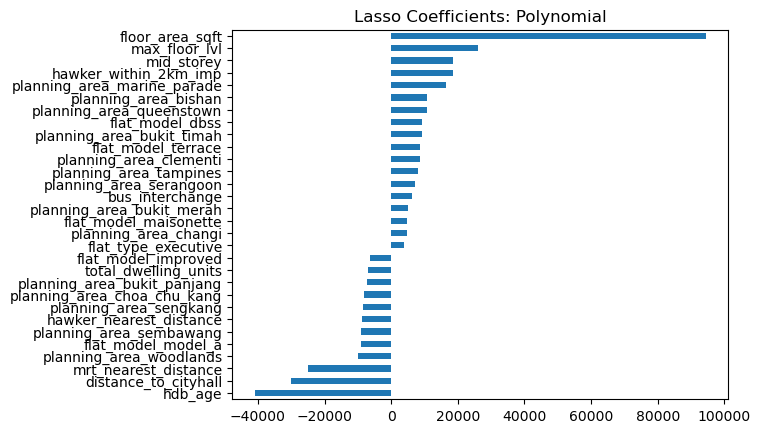

In [28]:
# Filter to narrow down to top 30 features and sorted
pd.Series(lasso_2_coef, index=features_b).sort_values().plot.barh()

plt.title("Lasso Coefficients: Polynomial");

Findings: <br>
Similar to Models 1 to 3, Models 4 to 6 for Features B have similar RMSE score between the 3 models and between training and hold out validation sets. There is little overfitting. This could be due to the small alpha.

As expected, the score is slightly worse (by less than 3,000), which is good considering the significant reduction in number of features.

Weightage of each features are similar to the earlier model. Floor area is the biggest factor by far, followed by HDB age. Convenience (Distance to Cityhall, nearest MRT and Hawkers) and floor level (top floor and unit floor) are next. Location wise, Woodlands and Sembawang in the North are factors for lower prices in this model; Marine Parade, Bishan and Queenstown are factors for higher prices.

### Features C: Use postal sector

For location, to try using postal sector instead of planning area as it segments into more locations. This might yield better results, at expense of having more features (one-hot).

In [29]:
features_c = [
    'floor_area_sqft',
    
    'max_floor_lvl',
    'mid_storey',
    'hdb_age',
    'bus_interchange',
    'mrt_interchange',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'distance_to_cityhall',
    'total_dwelling_units',
    'commercial',
    'hawker_within_2km_imp',
    'mall_within_2km_imp',

#    'flat_type_1_room',        ##drop this as base for one-hot
    'flat_type_2_room',
    'flat_type_3_room',
    'flat_type_4_room',
    'flat_type_5_room',
    'flat_type_executive',
    'flat_type_multi_generation',

#    'flat_model_2_room',        ##drop this as base for one-hot
    'flat_model_adjoined_flat',
    'flat_model_apartment',
    'flat_model_dbss',
    'flat_model_improved',
    'flat_model_improved_maisonette',
    'flat_model_maisonette',
    'flat_model_model_a',
    'flat_model_model_a2',
    'flat_model_model_a_maisonette',
    'flat_model_multi_generation',
    'flat_model_new_generation',
    'flat_model_premium_apartment',
    'flat_model_premium_apartment_loft',
    'flat_model_premium_maisonette',
    'flat_model_simplified',
    'flat_model_standard',
    'flat_model_terrace',
    'flat_model_type_s1',
    'flat_model_type_s2',
     
#    'postal_sector_5',        ##drop this as base for one-hot
    'postal_sector_8',
    'postal_sector_9',
    'postal_sector_10',
    'postal_sector_12',
    'postal_sector_13',
    'postal_sector_14',
    'postal_sector_15',
    'postal_sector_16',
    'postal_sector_18',
    'postal_sector_19',
    'postal_sector_20',
    'postal_sector_21',
    'postal_sector_26',
    'postal_sector_27',
    'postal_sector_30',
    'postal_sector_31',
    'postal_sector_32',
    'postal_sector_33',
    'postal_sector_35',
    'postal_sector_36',
    'postal_sector_37',
    'postal_sector_38',
    'postal_sector_39',
    'postal_sector_40',
    'postal_sector_41',
    'postal_sector_42',
    'postal_sector_43',
    'postal_sector_44',
    'postal_sector_46',
    'postal_sector_47',
    'postal_sector_50',
    'postal_sector_51',
    'postal_sector_52',
    'postal_sector_53',
    'postal_sector_54',
    'postal_sector_55',
    'postal_sector_56',
    'postal_sector_57',
    'postal_sector_59',
    'postal_sector_60',
    'postal_sector_61',
    'postal_sector_64',
    'postal_sector_65',
    'postal_sector_66',
    'postal_sector_67',
    'postal_sector_68',
    'postal_sector_73',
    'postal_sector_75',
    'postal_sector_76',
    'postal_sector_79',
    'postal_sector_82',

    ]

# Number of features
len(features_c)

89

In [30]:
X_3 = flats[features_c]

# Train/test split to have holdout set
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3, y, random_state=42)

In [31]:
# Scale features
ss = StandardScaler()
ss.fit(X_train_3)
X_train_3 = ss.transform(X_train_3)
X_val_3 = ss.transform(X_val_3)

**Model 7: Linear Regression (using postal sector) -- selected for prediction**

In [32]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
lr_3_output = rmse_model(X_train_3, X_val_3, y_train_3, y_val_3, 'lr', 'Features_C', 10)
lr_3_output # to print RMSE and alpha

# Prediction
test_X_3 = flats_test[features_c]
test_X_3 = ss.transform(test_X_3)
predicted_price_3 = lr_3_output[0].predict(test_X_3) # to pull lr model instantiated

Features_C / LR RMSE train: 49818.98
Features_C / LR RMSE val: 49386.42


In [33]:
# Create dataFrame with id and predicted price
test_predict_3 = pd.DataFrame({'Id': flats_test['id'], 'Predicted': predicted_price_3})
test_predict_3.head()

,Id,Predicted
0,114982,325803.298626
1,95653,516204.022942
2,40303,346087.283242
3,109506,261139.705647
4,100149,457388.792185


In [34]:
# Export to csv
test_predict_3.to_csv('datasets/predict/test_predict_3.csv', index=False)

Findings: <br>
Model 7 (Linear Regression) using postal sector for locations showed better RMSE compared to Models 1 to 6. Between using postal sector or planning area as a location feature:
- postal sector has a better RMSE although it uses more features
- planning area uses less features and is more intuitive to audiences (e.g. "Choa Chu Kang" vs "68"). However, it has slightly worse RMSE.

Ridge or Lasso regression will not be generated for Features C because it is expected to have similar results to Linear Regression, based on the earlier models.

A prediction was submitted for this feature because it has the best RMSE results for a reasonable model. Like earlier models, there seems to be little overfitting when comparing train, validation and test results.

### Features D: Use target encoding

For flat type, flat model and postal sector, to try using target encoding to reduce the number of features due to one-hot encoding. Only simple mean of price per square feet for each category is used, with no assignment of weight of category vs overall mean or other factors.

In [35]:
features_d = [
    'floor_area_sqft',
    
    'max_floor_lvl',
    'mid_storey',
    'hdb_age',
    'bus_interchange',
    'mrt_interchange',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'distance_to_cityhall',
    'total_dwelling_units',
    'commercial',
    'hawker_within_2km_imp',
    'mall_within_2km_imp',
    
    'flat_type_tgt',
    'flat_model_tgt',
    
#    'planning_area_tgt', # to use postal sector for location as it yields the better results
    'postal_sector_tgt',

    ]

# Number of features
len(features_d)

16

In [36]:
X_4 = flats[features_d]

# Train/test split to have holdout set
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_4, y, random_state=42)

In [37]:
# Scale features
ss = StandardScaler()
ss.fit(X_train_4)
X_train_4 = ss.transform(X_train_4)
X_val_4 = ss.transform(X_val_4)

**Model 8: Linear Regression (Basic target encoding)**

In [38]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
rmse_model(X_train_4, X_val_4, y_train_4, y_val_4, 'lr', 'Features_D', 10)

Features_D / LR RMSE train: 56908.03
Features_D / LR RMSE val: 56619.59


(LinearRegression(),
 array([ 96453.36283796,  14625.06612285,  18452.2822828 , -34594.05375852,
          7212.74196832,   -387.57486088, -22613.97397479, -16832.51155847,
        -24566.51270365,  -7155.12488683,  -1758.33126277,   2280.27804907,
         -9516.91992831,  -6593.08381274,  12769.02867849,  44333.11021203]))

Findings: <br>
This reduced the number of features drastically to 16. RMSE is higher but still reasonable (less than 60,000) and there is little overfit when comparing training and validation results.

The advantage is that this model is simple and easy to understand. This is also the disadvantage because the target encoded features cannot be adjusted for specific characteristics. For example, distance to cityhall feature will already cover price premium due to travel convenience, but target encoding will not allow this characteristics to be "priced out" of specific locations (e.g. Outram) in the model since location is one whole feature by itself.

Ridge or Lasso regression will not be generated for Features D because it is expected to have similar results to Linear Regression, based on the earlier models.

### Features E: Polynomial

Features E will use polynomial while taking the strong points from previous Features, to try improve or maintain the score while reducing the number of features:
- From Model 3 (Lasso for all selected features), we managed to identify the features with greatest coefficients
- In Models 4-6, we simulated models for 30 of these selected features, and found that this could reduce the number of features while having small impact to RMSE score.
- From Model 7, we simulated model using postal code as location, and found it reduced RMSE score while adding more features.
- From Model 8, we found that target encoding can reduce the number of features significantly. However, it gave the worse RMSE score.

For Features E, we will use only those few features with the greatest coefficients (from Features B). We will further reduce the number of features by using postal code with target encoding, replacing those planning area / postal code one-hot encoding features. <br><br>


*Resale price = Floor area x Price per area* <br>
Thus for the polynomial we will take 'floor_area_sqft' x each feature that affects Price per area. <br>
Features selected relate to hdb age, floor level, location and convenience which logically should not be related to area. Furthermore, hdb age, floor level and convenience have shown to have low correlation to area based on correlation map in EDA in *Part 1*. As such, there should be minimal noise when these Features (related to Price per area but not Area) are multiplied by Floor Area.<br>

We included floor area sqft as a non-polynomial feature to fully cover *area* that has not been already covered by the Polynomial features. <br>
Other non-polynomial features are:
- Total dwelling units. From EDA scatterplot in *Part 1*, it seems to show clearer linear relationship with area, while having little relationship with price per area
- Selected flat model and types with larger coefficients. From EDA boxplot in *Part 1*, DBSS and Terrace shows higher price per area but the quantity are too few to have significant impact. For the other models/types, it is unclear if these are linearly related with price per area. As such, took it simply to be non-polynomial.

In [39]:
set_a = 'floor_area_sqft'

set_b = [
    'hdb_age',
    'hawker_within_2km_imp',
    'hawker_nearest_distance',
    'mrt_nearest_distance',
    'distance_to_cityhall',
    'bus_interchange',
    'max_floor_lvl',
    'mid_storey',
    
    'postal_sector_tgt',  
    ]

features_e = [            # store non-polynomial features in feature_e
    'floor_area_sqft', 
    'total_dwelling_units',
    'flat_model_dbss',
    'flat_model_terrace',
    'flat_model_maisonette',
    'flat_model_improved',
    'flat_model_model_a',
    'flat_type_executive',
    ]

# create new columns by multiplying set_a by set_b to get polynomial
for col in set_b:
    flats[col + '_x_' + set_a] = flats[col] * flats[set_a] # for training set
    flats_test[col + '_x_' + set_a] = flats_test[col] * flats_test[set_a] # for test set

    features_e.append(col + '_x_' + set_a) # store polynomial features in features_e
    
len(features_e)

17

In [40]:
X_5 = flats[features_e]

# Train/test split to have holdout set
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(X_5, y, random_state=42)

In [41]:
# Scale features
ss = StandardScaler()
ss.fit(X_train_5)
X_train_5 = ss.transform(X_train_5)
X_val_5 = ss.transform(X_val_5)

**Model 9: Linear Regression (Polynomial)**

In [42]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
rmse_model(X_train_5, X_val_5, y_train_5, y_val_5, 'lr', 'Features_E', 10)

Features_E / LR RMSE train: 50926.87
Features_E / LR RMSE val: 50415.29


(LinearRegression(),
 array([ 44197.06318161,  -4703.65995358,  13238.07292251,   8021.65727857,
          5810.84734576,  -4515.35478919,  -3451.85567591,   7636.84772589,
        -33432.95445424,   2571.66171352, -15823.63512387, -24389.42527001,
        -20649.19605184,   5375.70245664,  17982.32901975,  19788.91990292,
         85468.72830676]))

**Model 10: Ridge (Polynomial)**

In [43]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
rmse_model(X_train_5, X_val_5, y_train_5, y_val_5, 'ridge', 'Features_E', 5)

Features_E / RIDGE RMSE train: 50928.25
Features_E / RIDGE RMSE val: 50415.35
best alpha: 2.95


(RidgeCV(alphas=array([ 0.5       ,  0.59798995,  0.6959799 ,  0.79396985,  0.8919598 ,
         0.98994975,  1.0879397 ,  1.18592965,  1.2839196 ,  1.38190955,
         1.4798995 ,  1.57788945,  1.6758794 ,  1.77386935,  1.8718593 ,
         1.96984925,  2.0678392 ,  2.16582915,  2.2638191 ,  2.36180905,
         2.45979899,  2.55778894,  2.65577889,  2.75376884,  2.85175879,
         2.94974874,  3.04773869,  3.14572864,  3.24371859,  3.34170854,
         3.43969849,  3.5...
        17.15829146, 17.25628141, 17.35427136, 17.45226131, 17.55025126,
        17.64824121, 17.74623116, 17.84422111, 17.94221106, 18.04020101,
        18.13819095, 18.2361809 , 18.33417085, 18.4321608 , 18.53015075,
        18.6281407 , 18.72613065, 18.8241206 , 18.92211055, 19.0201005 ,
        19.11809045, 19.2160804 , 19.31407035, 19.4120603 , 19.51005025,
        19.6080402 , 19.70603015, 19.8040201 , 19.90201005, 20.        ]),
         cv=5),
 array([ 44190.89954016,  -4705.24344888,  13238.31095698,   8

**Model 11: Lasso (Polynomial) -- selected for prediction**

In [44]:
# for model: to input one of 'lr', 'ridge', 'lasso'
# for feature: to input feature name for reference
# for cv_input: to input cross validation
lasso_5_output = rmse_model(X_train_5, X_val_5, y_train_5, y_val_5, 'lasso', 'Features_E', 10)
lasso_5_output # to print RMSE and alpha

lasso_5_coef = lasso_5_output[-1] # to pull coeff for lasso

# Prediction
test_X_5 = flats_test[features_e]
test_X_5 = ss.transform(test_X_5)
predicted_price_5 = lasso_5_output[0].predict(test_X_5)  # to pull lasso model instantiated

Features_E / LASSO RMSE train: 50931.99
Features_E / LASSO RMSE val: 50430.37
best alpha: 122.47


In [45]:
# Create dataFrame with id and predicted price
test_predict_5 = pd.DataFrame({'Id': flats_test['id'], 'Predicted': predicted_price_5})
test_predict_5.head()

,Id,Predicted
0,114982,414571.955067
1,95653,628344.545428
2,40303,298832.273288
3,109506,430978.193906
4,100149,442824.431701


In [46]:
# Export to csv
test_predict_5.to_csv('datasets/predict/test_predict_5.csv', index=False)

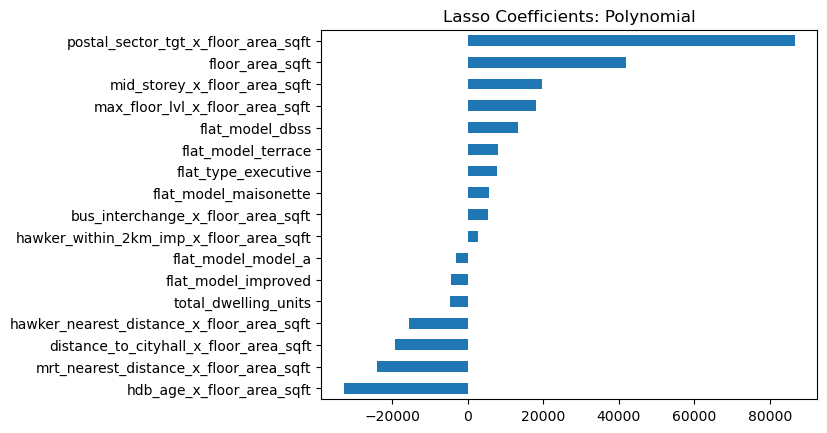

In [47]:
# Sorted and plot bar chart
pd.Series(lasso_5_coef, index=features_e).sort_values().plot.barh()

plt.title("Lasso Coefficients: Polynomial");

Findings: <br>
Training and validation scores are respectable with little overfitting (around RMSE of 51000 each). However, when tested using the Kaggle test set, there is severe overfitting (around RMSE of 95000). This could be because of the the use of both target-encoding and polynomials which was too specific to the training dataset: as seen in the bargraph, the postal_sector_x_floor_area (which was target-encoded) had the most weight by far compared to other features, after standard scaling.

As such we will not use this model.

---
## Evaluation
---

|Model|Feature|No. of Features|RMSE-Train|RMSE-Test|RMSE-CSV|Alpha|Pros|Cons|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|1. Linear Regression|A: All selected features|69|50961.79|50570.82|NA|NA|Good score|Too many features|
|2. Ridge|A: All selected features|69|50963.46|50571.95|NA|6.87|Good score|Too many features|
|3. Lasso|A: All selected features|69|50977.23|50606.31|NA|93.7|Good score|Too many features|
|4. Linear Regression|B: Reduced features|30|52197.26|51888.27|NA|NA|Reasonable score, key features|Key features may change|
|5. Ridge|B: Reduced features|30|52200.24|51888.31|NA|5.11|Reasonable score, key features|Key features may change|
|6. Lasso|B: Reduced features|30|52200.22|51892.73|52706.10|93.7|Reasonable score, key features|Key features may change|
|7. Linear Regression|C: Used postal sector|89|49818.98|49386.42|49880.84|NA|Best score|Too many features|
|8. Linear Regression|D: Basic target encoding|16|56908.03|56619.59|NA|NA|Minimal features|Worst score, oversimple|
|9. Linear Regression|E: Polynomial|15|50926.87|50415.29|NA|NA|Minimal features|Overfitted|
|10. Ridge|E: Polynomial|17|50928.25|50415.35|NA|2.95|Minimal features|Overfitted|
|11. Lasso|E: Polynomial|17|50931.99|50430.37|95063.32|122.47|Minimal features|Overfitted|

Refer to table for summary of models and scores, as well as pros and cons. As seen in the table, all models score around 50,000 to 57,000 (with the exception of polynomial which has heavy overfitting). Increasing the number of features beyond the key ones have minimal impact on improving the RMSE. <br><br>


The model chosen is **Model 6: Lasso Regularisation for 30 key features**.

Although Model 7 has the best score, it use too many features. Model 4 to 6 is the most suitable model because it restricts the features to those that are key, and produces a reasonable score. There is also little overfitting. Features make sense and are explanable, relating to
- Floor area. The larger the area, the higher the price. This is the largest factor by far.
- HDB age. The longer the lease aged, the lower the price. This is the second largest factor.
- Convenience (5 features: distance to CBD, MRT, Hawker; Number of Hawkers; Bus interchange at nearest MRT)
- Location (14 selected planning areas). Marine Parade, Bishan and Queenstown are some locations which command higher prices in this model. Woodlands and Sembawang are some locations which command lower prices.
- Flat type and models (6 selected type/models, such as DBSS or Terrace which are more premium and more rare).
- Number of dwelling units. Denser flats may have more noise and are less attractive.

RMSE score for Model 4-6 at around 53,000 is reasonable for HDB flat price prediction, especially given the average flat price is SGD 449,000. There could be fluctuations in HDB prices that cannot be predicted based on the given data, such as condition of the flats. Research shows that the average cost of [renovation](https://www.singsaver.com.sg/blog/average-cost-of-home-renovations-singapore) is SGD 58,000 which is around the RMSE score.

Regularisation has minimal impact, so we could choose any of Linear Regression, Ridge and Lasso models. Lasso was selected to apply some regularisation, and because of the shorter run time for this particular project compared to Ridge.

---
## Conclusion and Recommendations
---

The prediction model for the real estate agent company is able to predict HDB resale prices with an RMSE of 53,000. Generally, buyers look most at size, age, convenience and location when purchasing the flats, as seen in the model. They may also consider flat types/models and how dense the flat is. The real estate agent company can consider focusing on these factors when selling the flat to their potential customers.

Possible improvements to project:
- larger dataset to reduce error and improve score
- more indicative features e.g. specific characteristics of each location; flat condition
- more advanced models rather than linear regression